In [1]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.stats import proportion
%matplotlib inline

In [2]:
def class_spitter(df):
    classes = np.unique(df.classification_system)
    cellarray = []
    for i in range(len(classes)):
        new = df.query(f"classification_system in @classes[{i}]")
        cellarray.append(new)
    return cellarray

def type_spitter(df):
    types = np.unique(df.cell_type)
    cellarray = []
    for i in range(len(types)):
        new = df.query(f"cell_type in @types[{i}]")
        cellarray.append(new)
    return cellarray

In [3]:
def Eucdistance_split(pre,post):
    x_pre,y_pre,z_pre = np.array(pre.pt_position_x)*4,np.array(pre.pt_position_y)*4,np.array(pre.pt_position_z)*40
    x_pos,y_pos,z_pos = np.array(post.pt_position_x)*4,np.array(post.pt_position_y)*4,np.array(post.pt_position_z)*40
    d = np.zeros(len(post))
    for i in range(len(post)):
        # divide by 1000 to convert to microns
        d[i] = np.sqrt((x_pre-x_pos[i])**2 + (y_pre-y_pos[i])**2 + (z_pre-z_pos[i])**2) / 1000.
    return d

def Raddistance_split(pre,post):
    x_pre,z_pre = np.array(pre.pt_position_x)*4,np.array(pre.pt_position_z)*40
    x_pos,z_pos = np.array(post.pt_position_x)*4,np.array(post.pt_position_z)*40
    d = np.zeros(len(post))
    for i in range(len(post)):
        # divide by 1000 to convert to microns
        d[i] = np.sqrt((x_pre-x_pos[i])**2 + (z_pre-z_pos[i])**2) / 1000.
    return d

In [4]:
def binomial_CI(df, bins):
    fail = []
    success = []
    # this makes sure my arrays are the same size - also no cells are less than 0 microns away
    fail.append(0)
    success.append(0)
    for i in range(len(bins)-1):
        # masking for specific distance bin
        masked_df = df[(df['r'] < bins[i+1]) & (df['r'] > bins[i])].reset_index(drop=True)
        # starting the counter
        f,s = 0,0
#         if len(masked_df) == 0:
#             print("this shit empty")
        for j in range(len(masked_df)):
            if masked_df['pre_pt_root_id'][j] == 0:
                f += 1
            else:
                s += 1
        fail.append(f)
        success.append(s)
    return np.array(fail),np.array(success)

In [5]:
client = CAVEclient(global_only=True)
# https://annotationframeworkclient.readthedocs.io/en/stable/guide/authentication.html#new-token
client = CAVEclient('minnie65_phase3_v1')

In [6]:
df = client.materialize.query_table('allen_v1_column_types_slanted',split_positions=True)

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# start cell
root_id = [864691135428608048]
boy = df.query("pt_root_id in @root_id")
# post-synaptic partners of starter cell
syn_unfiltered = client.materialize.query_table('synapses_pni_2',filter_equal_dict={'pre_pt_root_id':np.array(boy.pt_root_id)[0]})

In [8]:
correct_soma_table = client.info.get_datastack_info()['soma_table']
nuclei_unmasked = client.materialize.query_table(correct_soma_table,split_positions=True)
# new df of just neurons (no glial cells)
nuclei = nuclei_unmasked.query('cell_type == "neuron"').reset_index(drop=True)
# new column saying how many neurons have the same root_id
nuclei['num_soma'] = nuclei.groupby('pt_root_id').transform('count')['valid']
# mask the df to throw out merged nuclei (same root_id being assigned to multiple neurons)
mask_nuclei = nuclei['num_soma'] < 2
nuclei_full = nuclei[mask_nuclei].reset_index(drop=True)

In [9]:
unique_nuc = np.unique(nuclei_full.pt_root_id)
soma_full = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1',filter_in_dict = {'pt_root_id':unique_nuc},
                                          split_positions=True)

In [10]:
syn_nuc = syn_unfiltered.query("post_pt_root_id in @unique_nuc").reset_index(drop=True)

In [11]:
syn_nuc['num_syn'] = syn_nuc.groupby('post_pt_root_id').transform('count')['valid']

In [12]:
syn_nuc.rename(columns={'post_pt_root_id':'pt_root_id'}, inplace=True)

In [13]:
main_duplicates = pd.merge(soma_full,syn_nuc,on='pt_root_id',how='outer')[0:61847] # any cells after 61847 are not in the soma table
new_left = pd.merge(soma_full,syn_nuc,on='pt_root_id',how='left')
main = new_left.drop_duplicates(subset='pt_root_id', keep='first').reset_index(drop=True)
# groupby('pt_root_id') ag function, list synapse positions

In [14]:
main = main.drop(columns=['id_y', 'valid_y', 'pre_pt_supervoxel_id', 'post_pt_supervoxel_id', 
                          'pre_pt_position', 'post_pt_position'])

In [15]:
main = main.fillna(0)

In [16]:
main['d'] = Eucdistance_split(boy,main)
main['r'] = Raddistance_split(boy,main)

In [17]:
unique_syn_nuc = np.unique(syn_nuc.pt_root_id)
syn = main.query('pt_root_id in @unique_syn_nuc')
nonsyn = main.query('pt_root_id not in @unique_syn_nuc')

In [18]:
syn_class = class_spitter(syn)
nonsyn_class = class_spitter(nonsyn)

main_types = type_spitter(main)
syn_types = type_spitter(syn)
nonsyn_types = type_spitter(nonsyn)

In [19]:
r_interval = 25
upper_distance_limit = 400
bins_25 = np.array(range(0,upper_distance_limit,r_interval))
f,s = binomial_CI(main,bins_25)
# f_stack = np.stack((f,bins_25))
# s_stack = np.stack((s,bins_25))

In [20]:
f_type,s_type = [],[]
for i in range(len(main_types)):
    f,s = binomial_CI(main_types[i],bins_25)
    f_type.append(f)
    s_type.append(s)

In [21]:
# perc = []
# for i in range(len(f)):
#     if s[i] > 0:
#         p = s[i]/(s[i]+f[i])
#         perc.append(p)
#     else:
#         perc.append(0)

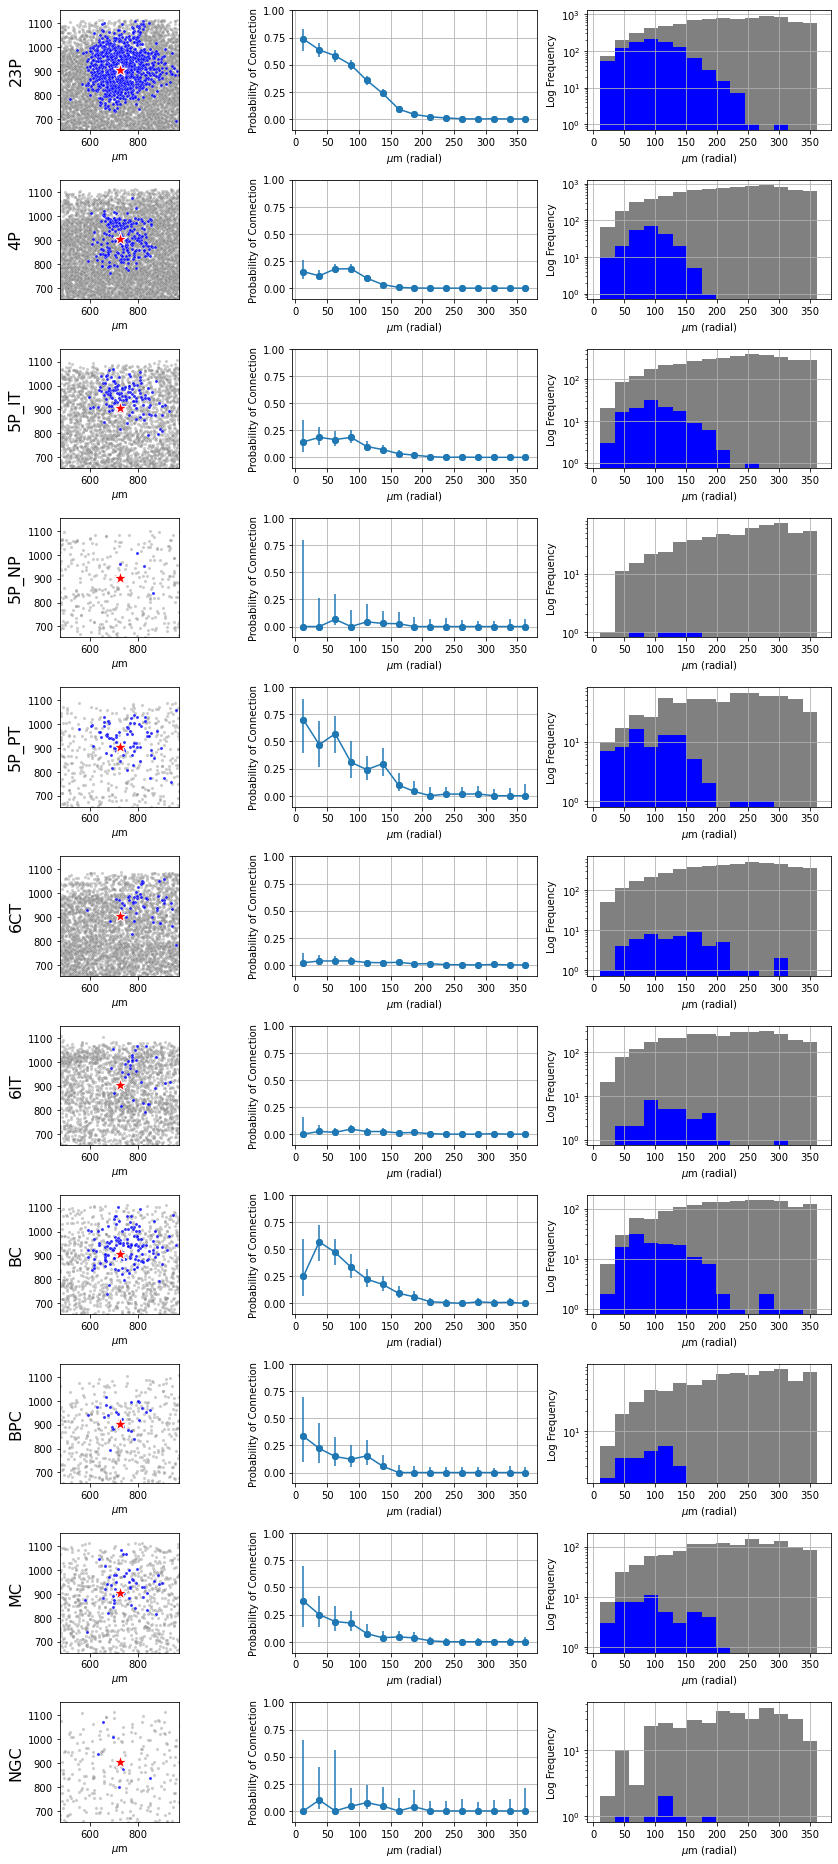

In [22]:
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(11,3)
fig.set_size_inches(12,26)

unique_types = np.unique(main.cell_type)
x = bins_25-(r_interval/2)
for i in range(len(unique_types)):
    sns.scatterplot(x=nonsyn_types[i].pt_position_x*(4/1000), y=nonsyn_types[i].pt_position_z*(40/1000), 
                    ax=ax[i,0], color='grey', alpha=.4, s=10)
    sns.scatterplot(x=syn_types[i].pt_position_x*(4/1000), y=syn_types[i].pt_position_z*(40/1000), 
                    ax=ax[i,0], color='b', alpha=.8, s=10).set_xlabel(r'$\mu$m')
    sns.scatterplot(x=boy.pt_position_x*(4/1000), y=boy.pt_position_z*(40/1000), marker='*',color='r',s=200,
                    ax=ax[i,0]).set_ylabel(unique_types[i], fontsize=16)
    xrange = [int(boy.pt_position_x*(4/1000))-250,int(boy.pt_position_x*(4/1000))+250]
    yrange = [int(boy.pt_position_z*(40/1000))-250,int(boy.pt_position_z*(40/1000))+250]
    ax[i,0].set_xlim(xrange[0],xrange[1])
    ax[i,0].set_ylim(yrange[0],yrange[1])
    ax[i,0].set_aspect('equal')
    
    method = 'wilson'
    errorbars = sm.stats.proportion.proportion_confint(s_type[i],nobs=(s_type[i]+f_type[i]),method=method)
    probability = (s_type[i]/(f_type[i]+s_type[i]))
    ax[i,1].scatter(x=x, y=probability)
    ax[i,1].errorbar(x=x, y=probability, yerr=(probability-errorbars[0],errorbars[1]-probability), fmt='-o') 
    ax[i,1].set_xlabel(r'$\mu$m (radial)', fontsize=10)
    ax[i,1].set_ylabel("Probability of Connection", fontsize=10)
    ax[i,1].set_ylim(-0.1,1.)
    ax[i,1].grid()
        
    ax[i,2].hist(x,bins=len(bins_25),weights=f_type[i]+s_type[i],density=False,label='Non-Synaptic', color='grey')
    ax[i,2].hist(x,bins=len(bins_25),weights=s_type[i],density=False,label='Synaptic', color='blue')
    ax[i,2].set_yscale('log')
    ax[i,2].set_xlabel(r'$\mu$m (radial)', fontsize=10)
    ax[i,2].set_xlim(-10,(max(bins_25)+10))
    ax[i,2].grid()
    ax[i,2].set_ylabel("Log Frequency", fontsize=10)

fig.tight_layout()
fig.savefig('blah.pdf')
#plt.show()

In [23]:
# warnings.filterwarnings('ignore')

# #fig, ax = plt.subplots(9,4)
# #fig.set_size_inches(15,22)

# unique_types = np.unique(main.cell_type)
# x = bins_25-(r_interval/2)
# for i in range(len(unique_types)):
#     if i < 4:
#         ax[0,i].set_title(unique_types[i], fontsize=18)
        
#         sns.scatterplot(x=nonsyn_types[i].pt_position_x*(4/1000), y=nonsyn_types[i].pt_position_z*(40/1000), 
#                         ax=ax[0,i], color='grey', alpha=.4).set_ylabel(r'$\mu$m')
#         sns.scatterplot(x=syn_types[i].pt_position_x*(4/1000), y=syn_types[i].pt_position_z*(40/1000), 
#                         ax=ax[0,i], color='b', alpha=.8).set_xlabel(r'$\mu$m')
#         sns.scatterplot(x=boy.pt_position_x*(4/1000), y=boy.pt_position_z*(40/1000), marker='*',color='r',s=200,
#                         ax=ax[0,i])#.set_ylabel(unique_types[i], fontsize=16)
#         xrange = [int(boy.pt_position_x*(4/1000))-250,int(boy.pt_position_x*(4/1000))+250]
#         yrange = [int(boy.pt_position_z*(40/1000))-250,int(boy.pt_position_z*(40/1000))+250]
#         ax[0,i].set_xlim(xrange[0],xrange[1])
#         ax[0,i].set_ylim(yrange[0],yrange[1])
#         ax[0,i].set_aspect('equal')

#         errorbars = sm.stats.proportion.proportion_confint(s_type[i],nobs=(s_type[i])+f_type[i])
#         probability = (s_type[i]/(f_type[i]+s_type[i]))
#         ax[1,i].scatter(x=x, y=probability)
#         ax[1,i].errorbar(x=x, y=probability, yerr=(errorbars[0]-probability,probability-errorbars[1]), fmt='-o') 
#         ax[1,i].set_xlabel(r'$\mu$m (radial)', fontsize=10)
#         ax[1,i].set_ylabel("Probability of Connection", fontsize=10)
#         ax[1,i].set_ylim(-0.1,1.)
#         ax[1,i].grid()

#         ax[2,i].hist(x,bins=len(bins_25),weights=f_type[i]+s_type[i],density=False,label='Non-Synaptic', color='grey')
#         ax[2,i].hist(x,bins=len(bins_25),weights=s_type[i],density=False,label='Synaptic', color='blue')
#         ax[2,i].set_yscale('log')
#         ax[2,i].set_xlabel(r'$\mu$m (radial)', fontsize=10)
#         ax[2,i].set_xlim(-10,(max(bins_25)+10))
#         ax[2,i].grid()
#         ax[2,i].set_ylabel("Log Frequency", fontsize=10)
#     if 4 <= i < 8:
#         ax[3,i-4].set_title(unique_types[i], fontsize=18)
        
#         sns.scatterplot(x=nonsyn_types[i].pt_position_x*(4/1000), y=nonsyn_types[i].pt_position_z*(40/1000), 
#                         ax=ax[3,i-4], color='grey', alpha=.4).set_ylabel(r'$\mu$m')
#         sns.scatterplot(x=syn_types[i].pt_position_x*(4/1000), y=syn_types[i].pt_position_z*(40/1000), 
#                         ax=ax[3,i-4], color='b', alpha=.8).set_xlabel(r'$\mu$m')
#         sns.scatterplot(x=boy.pt_position_x*(4/1000), y=boy.pt_position_z*(40/1000), marker='*',color='r',s=200,
#                         ax=ax[3,i-4])#.set_ylabel(unique_types[i], fontsize=16)
#         xrange = [int(boy.pt_position_x*(4/1000))-250,int(boy.pt_position_x*(4/1000))+250]
#         yrange = [int(boy.pt_position_z*(40/1000))-250,int(boy.pt_position_z*(40/1000))+250]
#         ax[3,i-4].set_xlim(xrange[0],xrange[1])
#         ax[3,i-4].set_ylim(yrange[0],yrange[1])
#         ax[3,i-4].set_aspect('equal')

#         errorbars = sm.stats.proportion.proportion_confint(s_type[i],nobs=(s_type[i])+f_type[i])
#         probability = (s_type[i]/(f_type[i]+s_type[i]))
#         ax[4,i-4].scatter(x=x, y=probability)
#         ax[4,i-4].errorbar(x=x, y=probability, yerr=(errorbars[0]-probability,probability-errorbars[1]), fmt='-o') 
#         ax[4,i-4].set_xlabel(r'$\mu$m (radial)', fontsize=10)
#         ax[4,i-4].set_ylabel("Probability of Connection", fontsize=10)
#         ax[4,i-4].set_ylim(-0.1,1.)
#         ax[4,i-4].grid()

#         ax[5,i-4].hist(x,bins=len(bins_25),weights=f_type[i]+s_type[i],density=False,label='Non-Synaptic', color='grey')
#         ax[5,i-4].hist(x,bins=len(bins_25),weights=s_type[i],density=False,label='Synaptic', color='blue')
#         ax[5,i-4].set_yscale('log')
#         ax[5,i-4].set_xlabel(r'$\mu$m (radial)', fontsize=10)
#         ax[5,i-4].set_xlim(-10,(max(bins_25)+10))
#         ax[5,i-4].grid()
#         ax[5,i-4].set_ylabel("Log Frequency", fontsize=10)
#     if 8 <= i < 12:
#         ax[6,i-8].set_title(unique_types[i], fontsize=18)
        
#         sns.scatterplot(x=nonsyn_types[i].pt_position_x*(4/1000), y=nonsyn_types[i].pt_position_z*(40/1000), 
#                         ax=ax[6,i-8], color='grey', alpha=.4).set_ylabel(r'$\mu$m')
#         sns.scatterplot(x=syn_types[i].pt_position_x*(4/1000), y=syn_types[i].pt_position_z*(40/1000), 
#                         ax=ax[6,i-8], color='b', alpha=.8).set_xlabel(r'$\mu$m')
#         sns.scatterplot(x=boy.pt_position_x*(4/1000), y=boy.pt_position_z*(40/1000), marker='*',color='r',s=200,
#                         ax=ax[6,i-8])#.set_ylabel(unique_types[i], fontsize=16)
#         xrange = [int(boy.pt_position_x*(4/1000))-250,int(boy.pt_position_x*(4/1000))+250]
#         yrange = [int(boy.pt_position_z*(40/1000))-250,int(boy.pt_position_z*(40/1000))+250]
#         ax[6,i-8].set_xlim(xrange[0],xrange[1])
#         ax[6,i-8].set_ylim(yrange[0],yrange[1])
#         ax[6,i-8].set_aspect('equal')

#         errorbars = sm.stats.proportion.proportion_confint(s_type[i],nobs=(s_type[i])+f_type[i])
#         probability = (s_type[i]/(f_type[i]+s_type[i]))
#         ax[7,i-8].scatter(x=x, y=probability)
#         ax[7,i-8].errorbar(x=x, y=probability, yerr=(errorbars[0]-probability,probability-errorbars[1]), fmt='-o') 
#         ax[7,i-8].set_xlabel(r'$\mu$m (radial)', fontsize=10)
#         ax[7,i-8].set_ylabel("Probability of Connection", fontsize=10)
#         ax[7,i-8].set_ylim(-0.1,1.)
#         ax[7,i-8].grid()

#         ax[8,i-8].hist(x,bins=len(bins_25),weights=f_type[i]+s_type[i],density=False,label='Non-Synaptic', color='grey')
#         ax[8,i-8].hist(x,bins=len(bins_25),weights=s_type[i],density=False,label='Synaptic', color='blue')
#         ax[8,i-8].set_yscale('log')
#         ax[8,i-8].set_xlabel(r'$\mu$m (radial)', fontsize=10)
#         ax[8,i-8].set_xlim(-10,(max(bins_25)+10))
#         ax[8,i-8].grid()
#         ax[8,i-8].set_ylabel("Log Frequency", fontsize=10)
    

#fig.tight_layout()
#fig.savefig('blahdiff.pdf')
#plt.show()